PillCam dataset trained on all classes with resnet50 without augmentation.  
- Fine tuning by unfreezing some layers (get aprox 90% accuracy)
- Early stopping
- Adaptive learning rate  
`TODO:`  
- DS resample  
- Class weighting  

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some parameters

In [3]:
data_dir = pathlib.Path('/mnt/sdb/augere_export_class/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'resnet50',
    "ds_info": 'complete',
    "resample": False,
    "neg_class": ['Normal'],
    "num_epochs": 100,
    "batch_size": 128,
    "img_shape": (32, 32, 3),
    "outcast": None,
    "optimizer": 'SGD',
    "final_activation": 'softmax',
    "learning_rate": 0.01,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

learning_rate = config["learning_rate"]
fine_tune_at = 130
fine_tune_epochs = 150
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py

In [4]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]

neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

## Training

### Resnet50 transfer learning
resnet50: https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/  
fine-tuning: https://www.tensorflow.org/tutorials/images/transfer_learning  
  and https://towardsdatascience.com/easy-image-classification-with-tensorflow-2-0-f734fee52d13  
callbacks: https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50  

In [5]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime

Create and compile the model

In [6]:
res_net = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=config["img_shape"]
)

# output = res_net.layers[-1].output
# output = Flatten()(output)

# res_net = Model(res_net.input, outputs=output)

In [7]:
# Freeze layers in resnet
res_net.trainable = True

# Define model
# resnet50_model = Sequential()

# resnet50_model.add(res_net)
# resnet50_model.add(GlobalAveragePooling2D())
# resnet50_model.add(Dense(params["NUM_CLASSES"], activation='softmax'))

global_average_layer = GlobalAveragePooling2D()
output_layer = Dense(params["num_classes"], activation=config["final_activation"])

resnet50_model = tf.keras.Sequential([
        res_net,
        global_average_layer,
        output_layer])

if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] #['sparse_categorical_accuracy']?
)

In [8]:
if config["verbosity"] > 0:
    resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
Total params: 23,604,104
Trainable params: 23,550,984
Non-trainable params: 53,120
_________________________________________________________________


`Reduce learning rate during training`

Callbacks

In [9]:
# By using LearnignRateScheduler
initial_learning_rate = learning_rate
decay_steps = params["train_size"] // config["batch_size"]
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb, earlystopp_cb, lr_schedule_cb]

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write( str(config) )
f.close()

Train the model

In [11]:
history = resnet50_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

# Write history dictionary to text file
f = open(log_dir+"/history.txt","w")
f.write( str(history.history) )
f.close()

Train for 243 steps, validate for 52 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
243/243 [==============================] - 96s 397ms/step - loss: 0.5243 - accuracy: 0.8506 - val_loss: 3.2331 - val_accuracy: 0.7456

Epoch 00002: LearningRateScheduler reducing learning rate to 0.008259687287559483.
Epoch 2/100
243/243 [==============================] - 12s 49ms/step - loss: 0.1890 - accuracy: 0.9433 - val_loss: 2.6130 - val_accuracy: 0.2120

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0070353213665315575.
Epoch 3/100
243/243 [==============================] - 12s 49ms/step - loss: 0.0889 - accuracy: 0.9737 - val_loss: 1.3951 - val_accuracy: 0.4552

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0061270801815431165.
Epoch 4/100
243/243 [==============================] - 12s 49ms/step - loss: 0.0454 - accuracy: 0.9884 - val_loss: 1.5070 - val_accuracy: 0.6013

Epoch 00005: LearningRateScheduler reducing learning 

`Keras`
Save/load the model

In [16]:
# resnet50_model.save('models/{}.h5'.format(model_name))
# resnet50_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [12]:
resnet50_evaluate = resnet50_model.evaluate(val_ds, verbose=2, steps=val_steps)

# Write evaluate dictionary to text file
f = open(log_dir+"/evaluate.txt","w")
f.write( str(resnet50_evaluate) )
f.close()

52/52 - 56s - loss: 0.0608 - accuracy: 0.9850


In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(history.epoch[-1]+1)

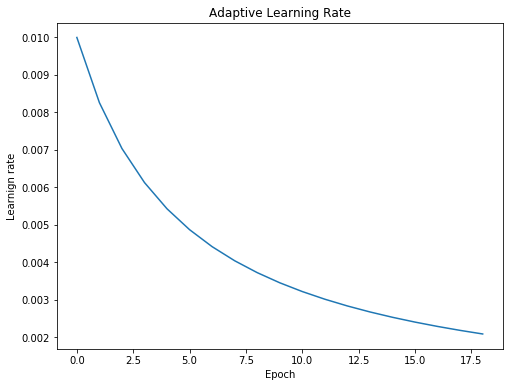

In [14]:
# Plot the learning rate
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, history.history['lr'], label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learnign rate')
plt.savefig(log_dir+'/learning_rate.png')
plt.title('Adaptive Learning Rate');

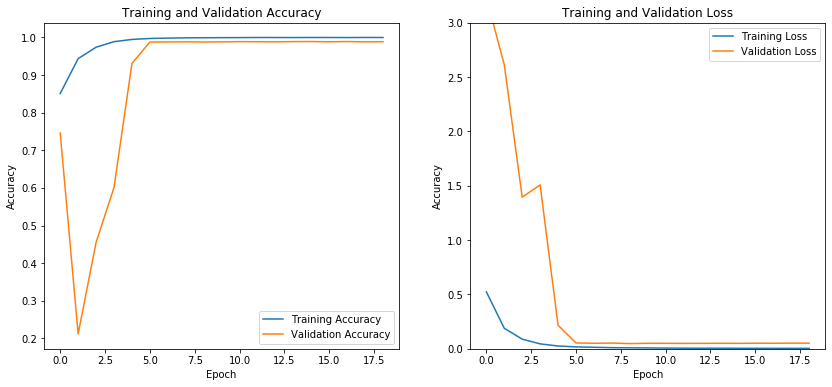

In [15]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.savefig(log_dir+'/accuracy_and_loss.png')
plt.show()

### Fine tune the model

In [16]:
res_net.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(res_net.layers))

# Fine-tune from this layer onwards
fine_tune_at = fine_tune_at

# Freeze all the layers before the `fine_tune_at` layer
for layer in res_net.layers[:fine_tune_at]:
    layer.trainable = False

print("Number of layers unfreezed: ", len(resnet50_model.trainable_variables))

Number of layers in the base model:  175
Number of layers unfreezed:  56


In [17]:
if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
fine_tune_epochs = fine_tune_epochs
total_epochs = history.epoch[-1] + fine_tune_epochs

history_fine = resnet50_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = total_epochs,
    initial_epoch = history.epoch[-1],
    validation_data = test_ds,
    validation_steps = val_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 243 steps, validate for 52 steps

Epoch 00019: LearningRateScheduler reducing learning rate to 0.0020865533230293664.
Epoch 19/168
243/243 [==============================] - 12s 51ms/step - loss: 0.0078 - accuracy: 0.9993 - val_loss: 0.0500 - val_accuracy: 0.9872

Epoch 00020: LearningRateScheduler reducing learning rate to 0.0019986839940779734.
Epoch 20/168
243/243 [==============================] - 8s 35ms/step - loss: 0.0077 - accuracy: 0.9991 - val_loss: 0.0501 - val_accuracy: 0.9872

Epoch 00021: LearningRateScheduler reducing learning rate to 0.0019179163378058406.
Epoch 21/168
243/243 [==============================] - 8s 34ms/step - loss: 0.0071 - accuracy: 0.9992 - val_loss: 0.0502 - val_accuracy: 0.9872

Epoch 00022: LearningRateScheduler reducing learning rate to 0.001843422849340009.
Epoch 22/168
243/243 [==============================] - 8s 34ms/step - loss: 0.0064 - accuracy: 0.9995 - val_loss: 0.0501 - val_accuracy: 0.9874

Epoch 00023: LearningRateScheduler r

In [19]:
# For fine-tuning
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

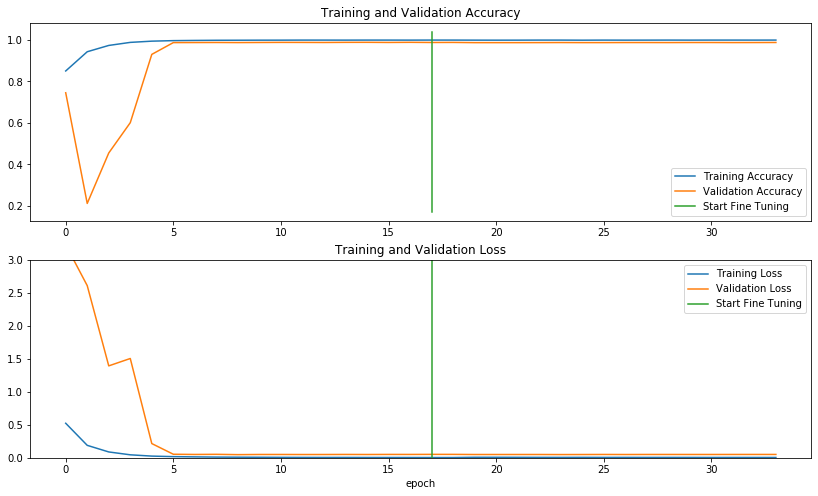

Fine tuning from epoch:  18


In [20]:
# Subplot 1
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

print ("Fine tuning from epoch: ", history.epoch[-1])

`Tensorboard`

In [ ]:
from tensorboard import notebook
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start tensorboard
%tensorboard --logdir logs

notebook.list()

## Predict new samples

In [21]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0002 Anatomic landmarks
0.0000 Unknown
0.0000 Protruding lesions
0.0000 Flat lesions
0.0003 Lumen
0.0000 Mucosa
0.9995 Normal
0.0000 Excavated lesions

Label: Normal
Predicton: Normal


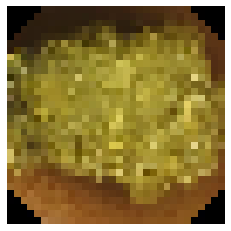

In [23]:
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [24]:
# Predict one batch
predictions = resnet50_model.predict(images)

print ('{:3}  {:<25} {:25}'.format('idx', 'label', 'pred'))
print ('---  {} {}'.format(25*'-', 25*'-'), end='')

# make a list to store the wrong predictions
wrong_predictions = []

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:25} {:25}'.format(i, label, prediction), end='')
    if (label != prediction): 
        print ("  Wrong", end='')
        wrong_predictions.append(i)

idx  label                     pred                     
---  ------------------------- -------------------------
  0  Normal                    Normal                   
  1  Anatomic landmarks        Anatomic landmarks       
  2  Normal                    Normal                   
  3  Anatomic landmarks        Anatomic landmarks       
  4  Anatomic landmarks        Anatomic landmarks       
  5  Anatomic landmarks        Anatomic landmarks       
  6  Anatomic landmarks        Anatomic landmarks       
  7  Excavated lesions         Excavated lesions        
  8  Normal                    Normal                   
  9  Normal                    Normal                   
 10  Normal                    Normal                   
 11  Normal                    Normal                   
 12  Lumen                     Lumen                    
 13  Normal                    Normal                   
 14  Anatomic landmarks        Anatomic landmarks       
 15  Normal                    

In [25]:
# Print info about wrong predictions
print("List of wrong predictions from batch:" ,wrong_predictions)
color_string = "\x1b[31m{:0.4f} {}\x1b[0m"

for i, wrong_pred in enumerate(wrong_predictions):
    # Get a random image and label
    rand = wrong_pred
    image = images[rand]
    label = labels[rand]
    
    # Predict one image
    predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]
    pred_label = np.argmax(predictions)
    
    print ("\n\nLabel:", params["class_names"][label])
    print ("Predicton:", params["class_names"][pred_label])
    print ("-------------------------------------")
    for i, pred in enumerate(predictions):
        # print in colors
        if i == pred_label:
            print(color_string.format(pred, params["class_names"][i]))
        else:
            print("{:0.4f} {}".format(pred,params["class_names"][i]))

#     plt.figure(frameon=False, facecolor='white')
#     plt.imshow(image)
#     plt.axis('off');

List of wrong predictions from batch: [61, 122]


Label: Anatomic landmarks
Predicton: Normal
-------------------------------------
0.0573 Anatomic landmarks
0.0000 Unknown
0.0000 Protruding lesions
0.0001 Flat lesions
0.0007 Lumen
0.0013 Mucosa
0.9405 Normal
0.0000 Excavated lesions


Label: Anatomic landmarks
Predicton: Normal
-------------------------------------
0.3338 Anatomic landmarks
0.0000 Unknown
0.0000 Protruding lesions
0.0000 Flat lesions
0.0003 Lumen
0.0000 Mucosa
0.6648 Normal
0.0010 Excavated lesions
